In [1]:
# Kütüphaneleri import ettik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [2]:
# Veriyi okuduk
df=pd.read_csv("insurance.csv")

In [3]:
# İlk 5 satırını getirdik
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Genel Bilgiler
def check_data(df,head=5):
    print("######## SHAPE ########") #Boyut bilgisi
    print(df.shape)
    print("######## TYPES ########")#Veri tipi bilgisi
    print(df.dtypes)
    print("######## HEAD ########")#İlk 5 satırı
    print(df.head(head))
    print("######## TAIL ########")#Son 5 satırı
    print(df.tail(head))
    print("######## NA ########")#Boş değer var mı?
    print(df.isnull().sum())
    print("######## DESCRIBE ########")#istatistiksel özeti
    print(df.describe())

In [5]:
check_data(df)

######## SHAPE ########
(1338, 7)
######## TYPES ########
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
######## HEAD ########
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
######## TAIL ########
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629.8335
1336   21  female  25.80         0     no  southwest   2007.9450
1337   61  female  29.07         

In [6]:
# Değişkenleri kontrol etme,Bazı sinsirellalar olabiliyor.
# Kategorik değişken,sayısal değişken olarak ayırdık  ama bazıları sayısal değişken iken kategorik değişken olabilir.
# Kategorik değişken iken kardinal değişken olabilir onu kontrol ettik.

def grab_col_names(df,cat_th=10,car_th=20):
    cat_cols=[col for col in df.columns if df[col].dtypes=="O"]# Tipi object olanları aldık
    
    # Normalde sayısal ama benzersiz sayısı 10'dan az ise kategorik değişken olarak aldık
    num_but_cat=[col for col in df.columns if df[col].nunique()<cat_th and df[col].dtypes!="O"]
    
    # Normalde kategorik değişken ama benzersiz sayısı 20'den fazla ise kardinal olarak aldık
    cat_but_car=[col for col in df.columns if df[col].nunique()>car_th and df[col].dtypes=="O"]
    
    cat_cols=[col for col in cat_cols if col not in cat_but_car]
    cat_cols=cat_cols+num_but_cat
    
    #Sayısal değişkenleri aldık
    num_cols=[col for col in df.columns if df[col].dtypes!="O"]
    
    #Sayısal değişknler içinden kategorik olarak alabileceklerimizi çıkarttık.
    num_cols=[col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols,cat_but_car
    
    

In [7]:
cat_cols, num_cols, cat_but_car=grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


### Kategorik Değişkenler İncelemesi

In [9]:
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),"Ratio":100*dataframe[col_name].value_counts()/len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
        print("--------------------------------------------------------------------------------------------")

        sex      Ratio
sex                   
male    676  50.523169
female  662  49.476831


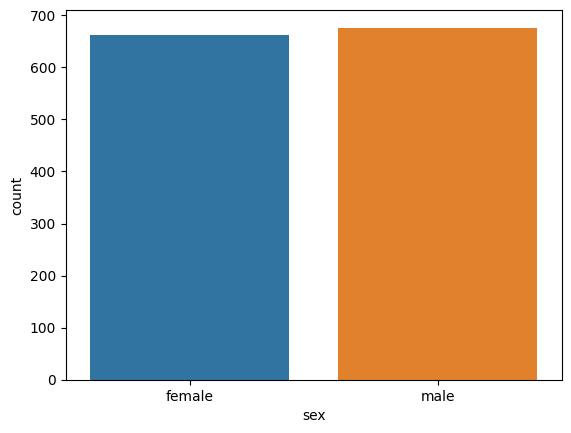

--------------------------------------------------------------------------------------------
        smoker      Ratio
smoker                   
no        1064  79.521674
yes        274  20.478326


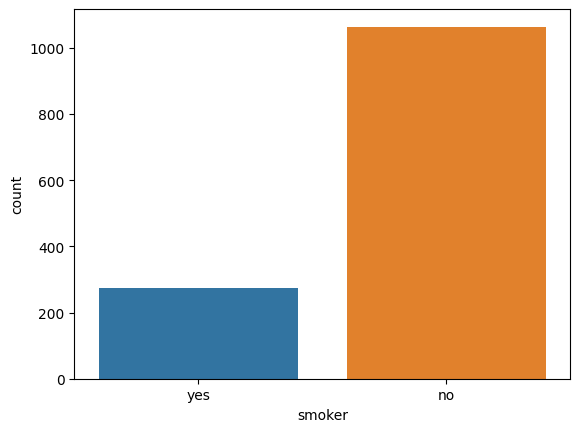

--------------------------------------------------------------------------------------------
           region      Ratio
region                      
southeast     364  27.204783
southwest     325  24.289985
northwest     325  24.289985
northeast     324  24.215247


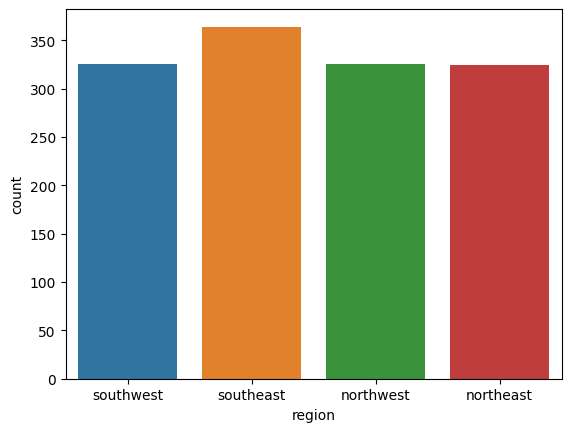

--------------------------------------------------------------------------------------------
          children      Ratio
children                     
0              574  42.899851
1              324  24.215247
2              240  17.937220
3              157  11.733931
4               25   1.868460
5               18   1.345291


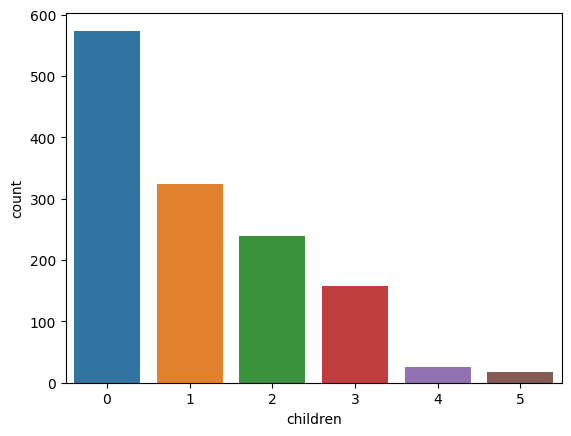

--------------------------------------------------------------------------------------------


In [10]:
for col in cat_cols:
    cat_summary(df,col,plot=True)

### Sayısal Değişkenlerin İncelenmesi

In [11]:
def num_summary(dataframe,numerical_col,plot=False):
    quantiles=[0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64


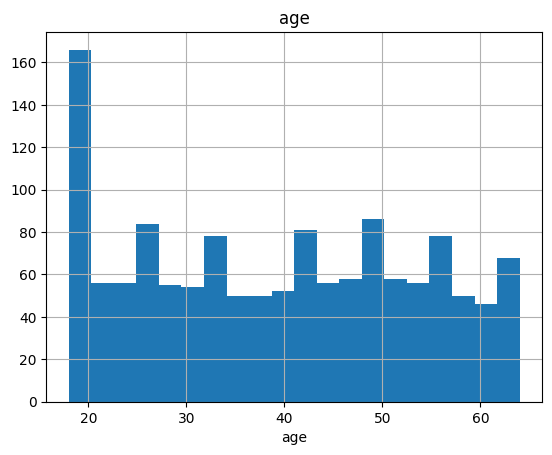

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


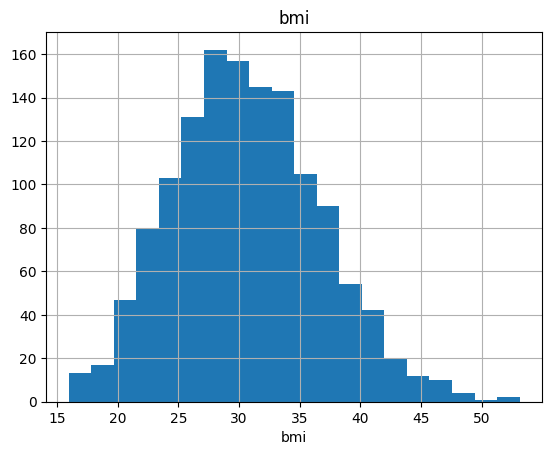

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64


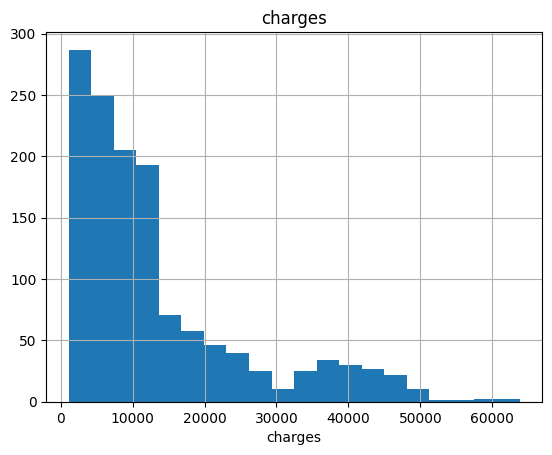

In [12]:
for col in num_cols:
    num_summary(df,col,plot=True)

## Değişkenler Arası İlişkiyi inceleme

###  Sigara içen ile içmeyen kişilerin masraflarını dairesel grafikle gösterdik.Sigara içenlerin sigara içmeyenlere göre masrafları çok daha fazla

([<matplotlib.patches.Wedge at 0x20eecd41e40>,
 [Text(0.8726887788136719, 0.6696374357312337, 'no'),
  Text(-0.8726887161176866, -0.6696375174382512, 'yes')],
 [Text(0.47601206117109374, 0.36525678312612747, '20.8%'),
  Text(-0.47601202697328354, -0.3652568276935915, '79.2%')])

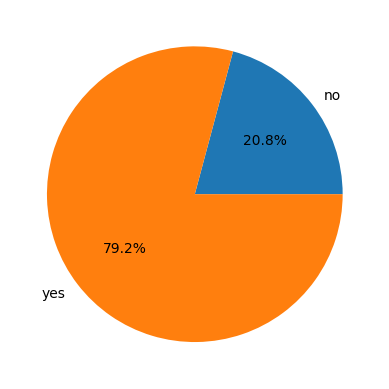

In [13]:
smoker_charges=df.groupby("smoker")["charges"].mean()
plt.pie(smoker_charges.values,labels=smoker_charges.index,autopct="%1.1f%%")

### Bölgelere göre sigara içilme miktarları ,Sigara içmeyenlerin sayısı sigara içenlerden daha fazla.Southeast bölgesi hem sigara içmede hem de sigara içmemede en yüksek.

Text(0.5, 1.0, 'Bölgelere göre sigara içilme miktarları')

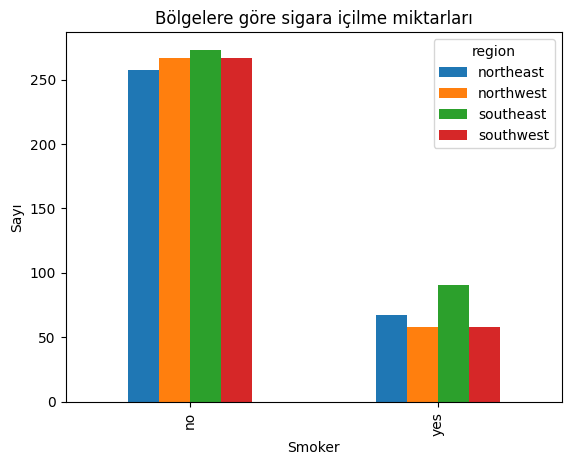

In [14]:
smoker_region=df.groupby("smoker")["region"].value_counts().unstack()
smoker_region.plot(kind="bar")
plt.xlabel("Smoker")
plt.ylabel("Sayı")
plt.title("Bölgelere göre sigara içilme miktarları")

### Vücut kitle endeksi ile cinsiyet arasındaki ilişki,hemen hemen yakınlar ama erkeklerin bmi biraz daha fazla

([<matplotlib.patches.Wedge at 0x20eec4e7400>,
 [Text(0.0159304664828703, 1.099884639513453, 'female'),
  Text(-0.015930466482870678, -1.099884639513453, 'male')],
 [Text(0.00868934535429289, 0.599937076098247, '49.5%'),
  Text(-0.008689345354293096, -0.599937076098247, '50.5%')])

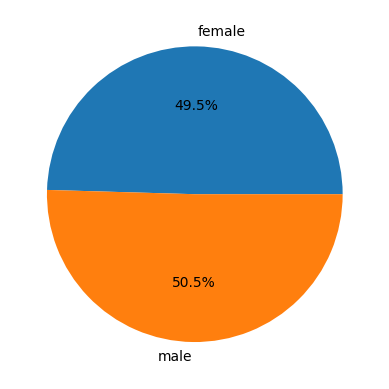

In [15]:
sex_bmi=df.groupby("sex")["bmi"].mean()
plt.pie(sex_bmi.values,labels=sex_bmi.index,autopct="%1.1f%%")

### Bölgelere göre çocuk sayısı,en fazla çocuk sayısına sahip bölge southeast

Text(0.5, 1.0, 'Bölgelere göre çocuk sayısı')

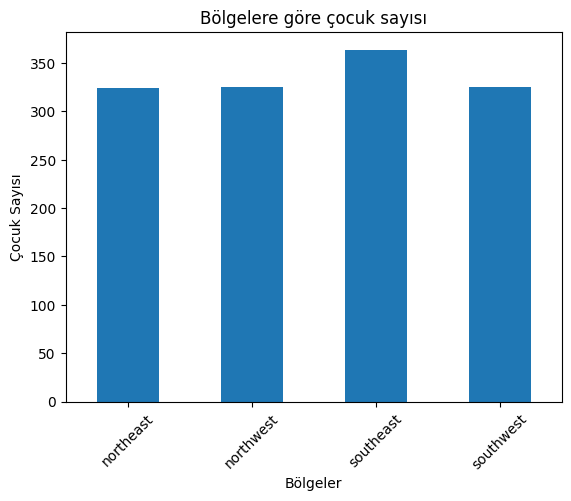

In [16]:
region_chd=df.groupby("region")["children"].count()
region_chd.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Bölgeler")
plt.ylabel("Çocuk Sayısı")
plt.title("Bölgelere göre çocuk sayısı")

### Yaş ve vücut kitle endeksi arasındaki ilişki,20-30 yaş arasında en az,Yaş-bmi  doğrusal bir ilişkisi olduğunu söyleyemiyoruz ,dengesiz dağılmış durumda 


Text(0.5, 1.0, 'Yaşlara göre bmi ortalamaları')

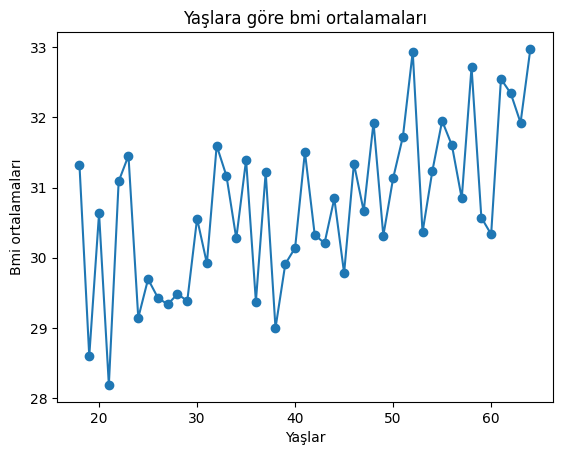

In [17]:
age_bmi=df.groupby("age")["bmi"].mean()
plt.plot(age_bmi.index,age_bmi.values,marker="o")
plt.xlabel("Yaşlar")
plt.ylabel("Bmi ortalamaları")
plt.title("Yaşlara göre bmi ortalamaları")

### Bmi ile çocuk sayısı arasındaki ilişki.5 çocuk sahibi olanlar en az bmi ortalamalarına sahip,hemen hemen hepsi birbirlerine yakın değerdeler.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

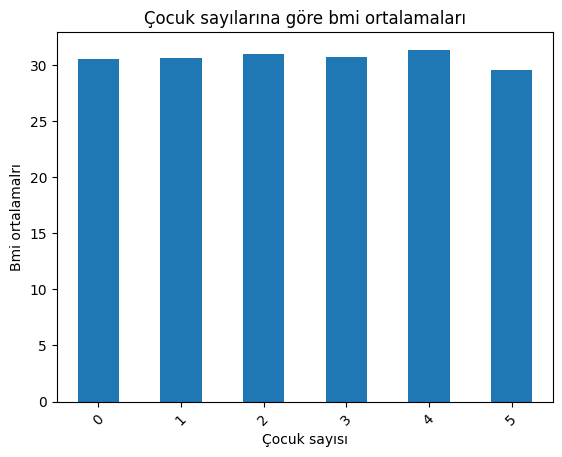

In [18]:
ch_bmi=df.groupby("children")["bmi"].mean()
ch_bmi.plot(kind="bar")
plt.xlabel("Çocuk sayısı")
plt.ylabel("Bmi ortalamalrı")
plt.title("Çocuk sayılarına göre bmi ortalamaları")
plt.xticks(rotation=45)

 ### Bmi ile charges arasındaki ilişkiye bakalım

Text(0.5, 1.0, 'Scatter Plot of BMI vs Charges')

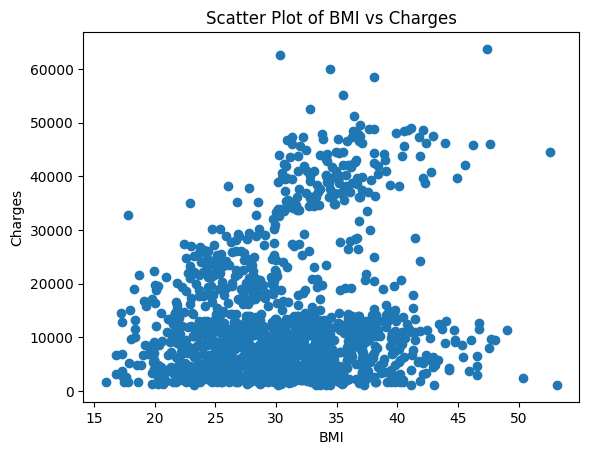

In [19]:
plt.scatter(df["bmi"],df["charges"])
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Scatter Plot of BMI vs Charges")

### Bmi ve charges arasındaki ilişkinin gücüne bakabilmek için öncelikle değişkenlerin dağılımlarına bakalım ve normallik varsayımlarını ölçelim. Shapiro-Wilk Testi ile normalliği ölçerken;
p < 0.05 Veriler normal Dağılmaz
p > 0.05 Veriler normal Dağılır varsayımlarını kullandık.


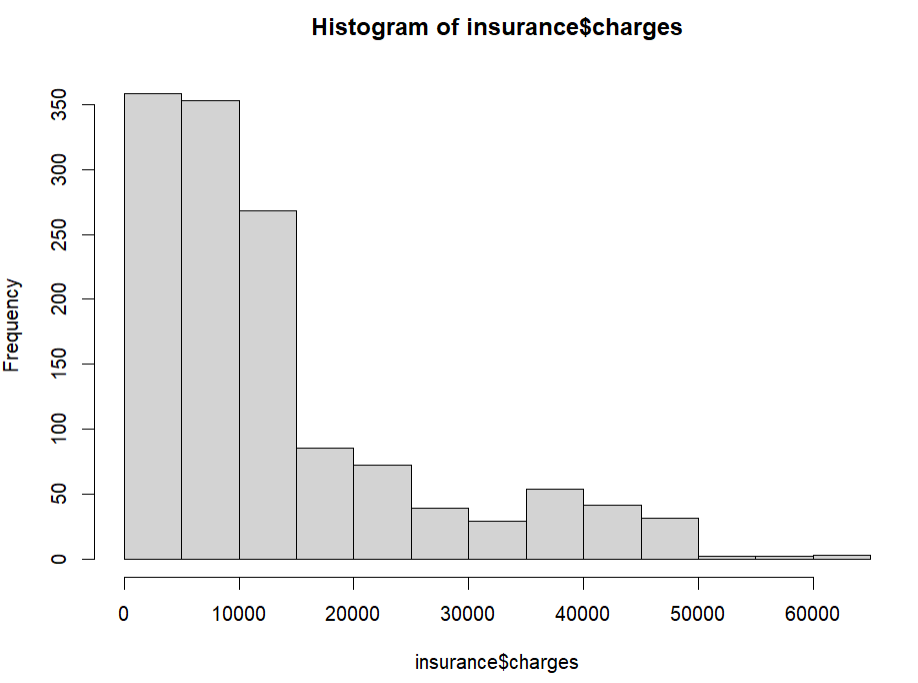

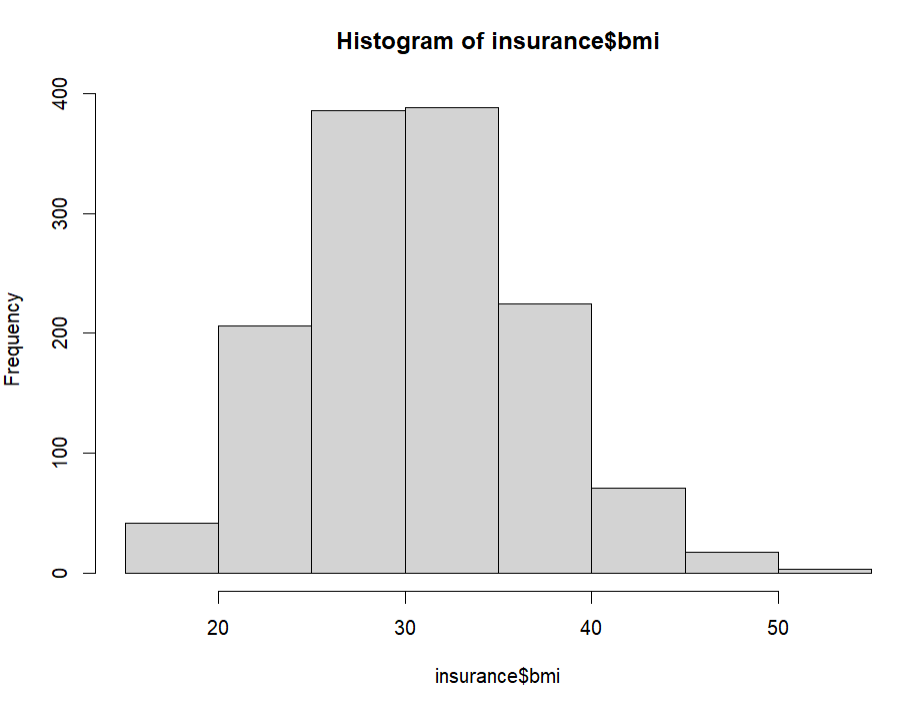

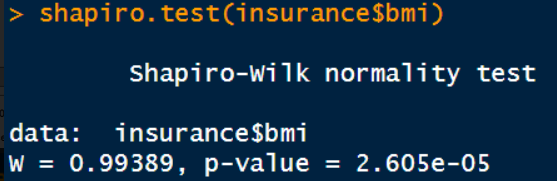

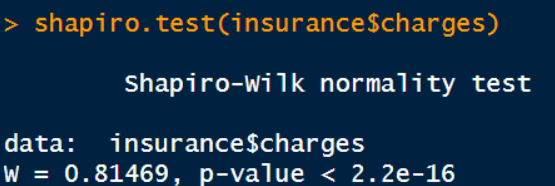

Verilerin normal dağılmadıkları gözlendikten sonra aralarındak ilişkiyi ölçmek için spearman korelasyonunu kullandık.Ve aralarındaki ilişkinin 0.11 gibi zayıf bir ilişki olduğunu gördük.

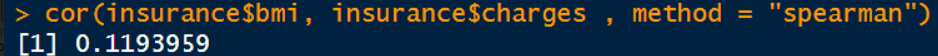

### Bölgelere ve sigara içip içilmediğine göre verileri gruplayıp bmi ortalamasını alıp görselleştirdik.En fazla bmi ort. Southeast sigara içmeyenler en az bmi ye sahip olanlar ise Northeast sigara içenler.

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(no, northeast)'),
  Text(1, 0, '(no, northwest)'),
  Text(2, 0, '(no, southeast)'),
  Text(3, 0, '(no, southwest)'),
  Text(4, 0, '(yes, northeast)'),
  Text(5, 0, '(yes, northwest)'),
  Text(6, 0, '(yes, southeast)'),
  Text(7, 0, '(yes, southwest)')])

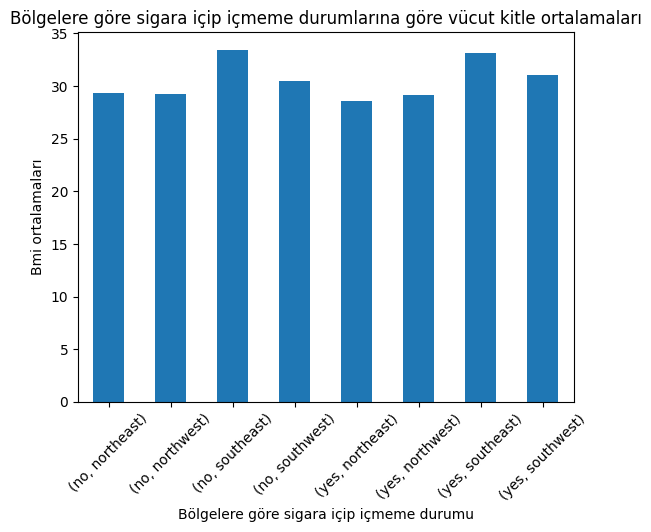

In [20]:
smoker_region_bmi=df.groupby(["smoker","region"])["bmi"].mean()
smoker_region_bmi.plot(kind="bar")
plt.xlabel("Bölgelere göre sigara içip içmeme durumu")
plt.ylabel("Bmi ortalamaları")
plt.title("Bölgelere göre sigara içip içmeme durumlarına göre vücut kitle ortalamaları")
plt.xticks(rotation=45)

### Sigara kullanma durumuna göre bmi ort inceleyince hemen hemen aynı bmi ortalamasına sahipler

Text(0.5, 1.0, 'Sigara kullanma durumuna göre bmi ortalamaları')

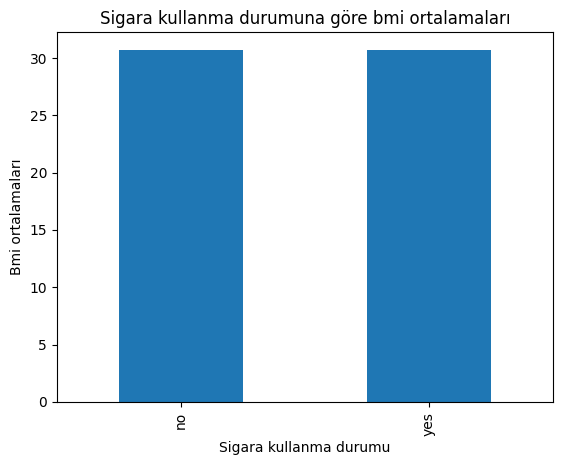

In [21]:
smoker_bmi=df.groupby("smoker")["bmi"].mean()
smoker_bmi.plot(kind="bar")
plt.xlabel("Sigara kullanma durumu")
plt.ylabel("Bmi ortalamaları")
plt.title("Sigara kullanma durumuna göre bmi ortalamaları")

### Sigara kullanımı ile  yaş ort ile arasındaki ilişkiyi  inceleyince az bir farkla sigara kullanmayanların yaş ort.daha fazla

Text(0.5, 1.0, 'Sigara kullanma durumuna göre yaş ortalamaları')

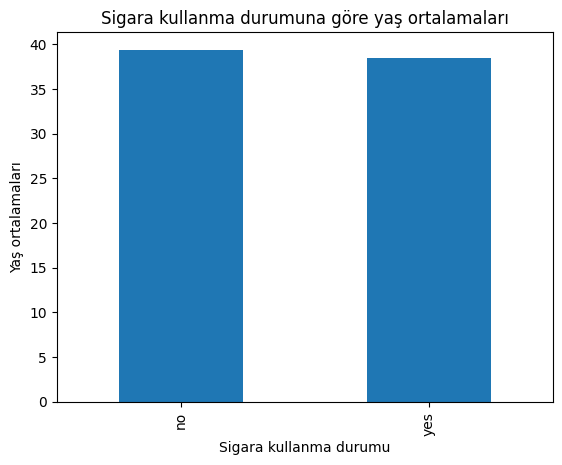

In [22]:
age_smoker=df.groupby("smoker")["age"].mean()
age_smoker.plot(kind="bar")
plt.xlabel("Sigara kullanma durumu")
plt.ylabel("Yaş ortalamaları")
plt.title("Sigara kullanma durumuna göre yaş ortalamaları")

### Bmi'de aykırı değer var gibi duruyor önce describene bakalım ,boxplota göre bütün sayısal değişkenleri inceleyelim bmi,charges aykırı değerler var .

In [23]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


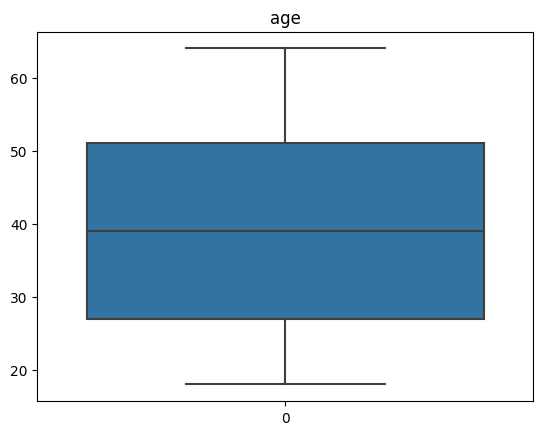

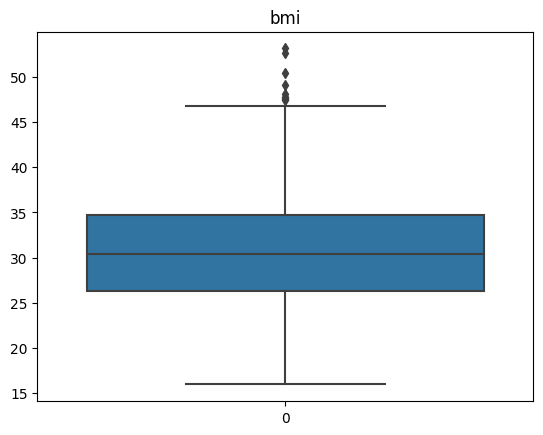

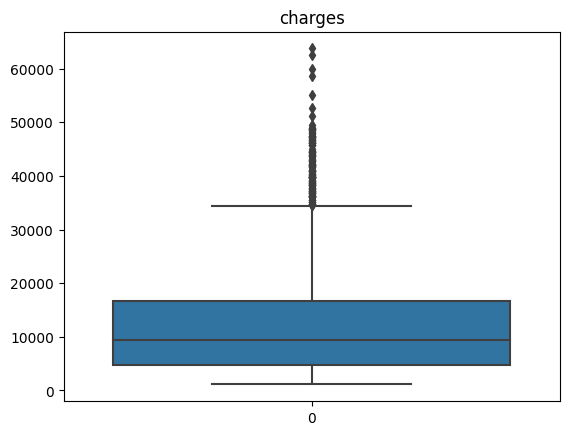

In [24]:
for col in num_cols:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show(block=True)

### Kod üzerinden kontrol edelim aykırı değer var mı diye 

In [25]:
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1=dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquantile_range=quartile3-quartile1
    up_limit=quartile3+1.5*interquantile_range
    low_limit=quartile1-1.5*interquantile_range
    
    return low_limit,up_limit

In [26]:
 def check_outlier(dataframe,col_name,q1=0.25,q3=0.75): 
        low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1,q3)
        if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):
            return True
        else:
            return False

In [27]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi True
charges True


### Aykırı Değerleri baskılayalım, hepsi false oldu aykırı değer problemini çözmüş olduk

In [28]:
def replace_with_thresholds(dataframe,variable,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,variable,q1,q3)
    dataframe.loc[(dataframe[variable]<low_limit),variable]=low_limit
    dataframe.loc[(dataframe[variable]>up_limit),variable]=up_limit

In [29]:
for col in num_cols:
    if check_outlier(df, col, q1=0.25, q3=0.75):
        replace_with_thresholds(df, col, q1=0.25, q3=0.75)

In [30]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi False
charges False


### Boxplot ile de bakalım

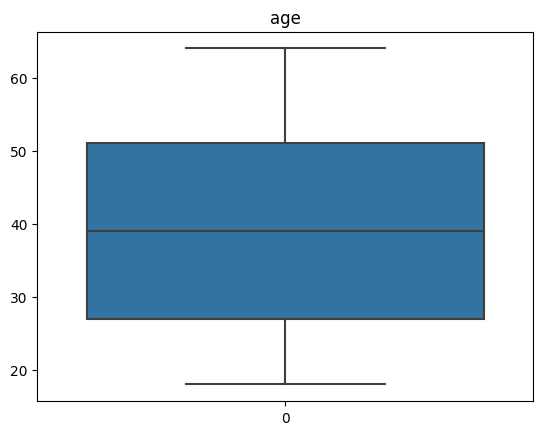

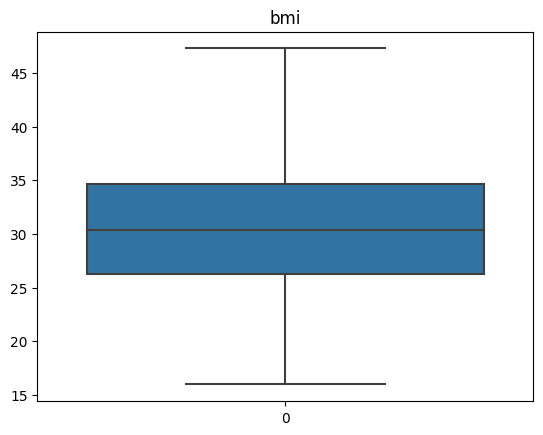

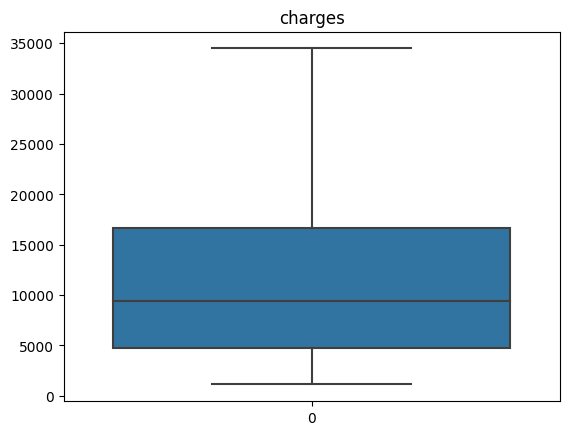

In [31]:
for col in num_cols:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show(block=True)

### Bmi'ye göre yeni değişken oluşturalım 

In [32]:
# En yüksek bmi değeri
df["bmi"].max()

47.290000000000006

In [33]:
# En düşük bmi değeri
df["bmi"].min()

15.96

 ###   15-18.5->Zayıf
 ###    18.5-24.9->Normal
 ###   24.9-29.9->Şişman
 ###   29.9-47->Obez  olarak kategorilere ayırdık

In [34]:
bin_edges = [15, 18.5, 24.9, 29.9, 47] 
bin_labels = ["Zayıf", "Normal", "Şişman", "Obez"]

# Categorize "bmi" values into bins
df["bmi_category"] = pd.cut(df["bmi"], bins=bin_edges, labels=bin_labels, right=False)


In [35]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,Şişman
1,18,male,33.770,1,no,southeast,1725.55230,Obez
2,28,male,33.000,3,no,southeast,4449.46200,Obez
3,33,male,22.705,0,no,northwest,21984.47061,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Şişman


### Modellemeye  başlamadan önce encoding işlemleri yaptık

### Label Encoding

In [36]:
def label_encoder(dataframe,binary_col):
    labelencoder=LabelEncoder()
    dataframe[binary_col]=labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [37]:
binary_cols=[col for col in df.columns if df[col].dtype not in [int,float] and df[col].nunique()==2]

In [38]:
binary_cols

['sex', 'smoker']

### one_hot_encoder

In [39]:
for col in binary_cols:
    df=label_encoder(df,col)

In [40]:
def one_hot_encoder(dataframe,cat_cols,drop_first=False):
    dataframe=pd.get_dummies(dataframe,columns=cat_cols,drop_first=drop_first)
    return dataframe

In [41]:
ohe_cols=[col for col in df.columns if 10>=df[col].nunique()>2]

In [42]:
ohe_cols

['children', 'region', 'bmi_category']

In [43]:
df=one_hot_encoder(df,ohe_cols,drop_first=True)

In [44]:
df.head()

,age,sex,bmi,smoker,charges,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest,bmi_category_Normal,bmi_category_Şişman,bmi_category_Obez
0,19,0,27.900,1,16884.92400,False,False,False,False,False,False,False,True,False,True,False
1,18,1,33.770,0,1725.55230,True,False,False,False,False,False,True,False,False,False,True
2,28,1,33.000,0,4449.46200,False,False,True,False,False,False,True,False,False,False,True
3,33,1,22.705,0,21984.47061,False,False,False,False,False,True,False,False,True,False,False
4,32,1,28.880,0,3866.85520,False,False,False,False,False,True,False,False,False,True,False


In [45]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations: 1338
Variables: 16
cat_cols: 13
num_cols: 3
cat_but_car: 0
num_but_cat: 13


### Scaler işlemi yaptık

### Robust-Scaler

In [46]:


for col in num_cols:
    transformer=RobustScaler().fit(df[[col]])
    df[col]=transformer.transform(df[[col]])

In [47]:
df.head()

,age,sex,bmi,smoker,charges,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest,bmi_category_Normal,bmi_category_Şişman,bmi_category_Obez
0,-0.833333,0,-0.297708,1,0.630515,False,False,False,False,False,False,False,True,False,True,False
1,-0.875000,1,0.401310,0,-0.643422,True,False,False,False,False,False,True,False,False,False,True
2,-0.458333,1,0.309616,0,-0.414515,False,False,True,False,False,False,True,False,False,False,True
3,-0.250000,1,-0.916344,0,1.059062,False,False,False,False,False,True,False,False,True,False,False
4,-0.291667,1,-0.181006,0,-0.463475,False,False,False,False,False,True,False,False,False,True,False


### Bağımlı-bağımsız değişken ayırdık

In [48]:
y = df['charges']
X = df.drop(["charges"], axis=1)

### Train/test olarak  test_size =0.20 belirleyerek ayırmış olduk

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Modelleme

In [57]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          #("LightGBM", LGBMRegressor()),#Lightgbm çok fazla uyarı verdiği için yorum satırına aldık.
          ("CatBoost", CatBoostRegressor(verbose=False))]


In [58]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


RMSE: 0.4284 (LR) 
RMSE: 0.4284 (Ridge) 
RMSE: 0.853 (Lasso) 
RMSE: 0.853 (ElasticNet) 
RMSE: 0.4877 (KNN) 
RMSE: 0.5465 (CART) 
RMSE: 0.3966 (RF) 
RMSE: 0.3585 (SVR) 
RMSE: 0.3678 (GBM) 
RMSE: 0.434 (XGBoost) 
RMSE: 0.3854 (CatBoost) 


### En iyi parametreleri bularak modelleme

In [59]:
#%%capture 
models = [
    ("Ridge", Ridge(), {"alpha": [0.1, 1.0, 10.0]}),
    ("RF", RandomForestRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}),
    ("XGBoost", XGBRegressor(objective='reg:squarederror'), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}),
    #("LightGBM", LGBMRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}),#Lightgbm çok fazla uyarı verdiği için yorum satırına aldık.
    ("CatBoost", CatBoostRegressor(verbose=False), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}),
    ("SVR",SVR(),{ 'C': [0.1, 1, 10],'kernel': ['linear', 'poly', 'rbf']})
]

# Grid Search ile en iyi parametreleri bulma
for name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)
    print(f"Best Parameters for {name}: {best_params}")
    print(f"Best RMSE: {round(best_score, 4)}")

Best Parameters for Ridge: {'alpha': 1.0}
Best RMSE: 0.4293
Best Parameters for RF: {'max_depth': 10, 'n_estimators': 200}
Best RMSE: 0.3917
Best Parameters for XGBoost: {'max_depth': 3, 'n_estimators': 50}
Best RMSE: 0.375
Best Parameters for CatBoost: {'max_depth': 3, 'n_estimators': 200}
Best RMSE: 0.3689
Best Parameters for SVR: {'C': 1, 'kernel': 'rbf'}
Best RMSE: 0.361


In [ ]:
Parametrelerden Önce RMSE hali

RMSE: 0.4284 (Ridge) 
RMSE: 0.3966 (RF)  
RMSE: 0.434 (XGBoost)  
RMSE: 0.3898 (LightGBM) 
RMSE: 0.3854 (CatBoost) 
RMSE: 0.3585 (SVR)

Parametrelerden Sonra RMSE hali

Best Parameters for Ridge: {'alpha': 1.0}
Best RMSE: 0.4293
Best Parameters for RF: {'max_depth': 10, 'n_estimators': 200}
Best RMSE: 0.3917
Best Parameters for XGBoost: {'max_depth': 3, 'n_estimators': 50}
Best RMSE: 0.375
Best Parameters for LightGBM: {'max_depth': 3, 'n_estimators': 50}
Best RMSE: 0.3602
Best Parameters for CatBoost: {'max_depth': 3, 'n_estimators': 100}
Best RMSE: 0.3689
Best Parameters for SVR: {'C': 1, 'kernel': 'rbf'}
Best RMSE: 0.361